### Recommender movie system
In this notebook i'll attempt to implement the algorithms of contentent based filtering and collaborative filtering and try to build an ensemble of these models to come up with our final recommendation system.
<br>
<br>
I'm going to use the MovieLens data set, there is the two options of large and small: \
    The large one: Consists of 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. 
    <br>Includes tag genome data with 12 million relevance scores across 1,100 tags.
    <br>
    The small one: Comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.
    <br>
I'll build the recommender based on the small data set.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import linear_kernel
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from ast import literal_eval


In [2]:
mv = pd.read_csv('../ml-latest-small/movies.csv')
mv.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
tags = pd.read_csv('../ml-latest-small/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


This table shows how users discribed the watched movies.

In [4]:
ratings = pd.read_csv('../ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


The rating table displays how users have rated the movies. We can use this data to identify the top 10 movies that have been highly rated by users. Initially, we need to create a new table that comprises the movie ID and the number of votes received for each movie.

In [5]:
count_ratings = ratings.groupby('movieId')['userId'].count().reset_index(name='vote_count')
count_ratings.head()

,movieId,vote_count
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49


Let's merge the two tables to use them for data vizualization and future predictions

In [6]:
merge_dataset = pd.merge(ratings,mv, how='inner',on='movieId')

In [7]:
merge_dataset.drop(columns='timestamp')

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...
100831,610,160341,2.5,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,Blair Witch (2016),Horror|Thriller


### Data Visualization & Recommendations through Data Analysis for a new use(content based filtering and collaborative filtering)

Text(0, 0.5, 'Number of times a rating was given')

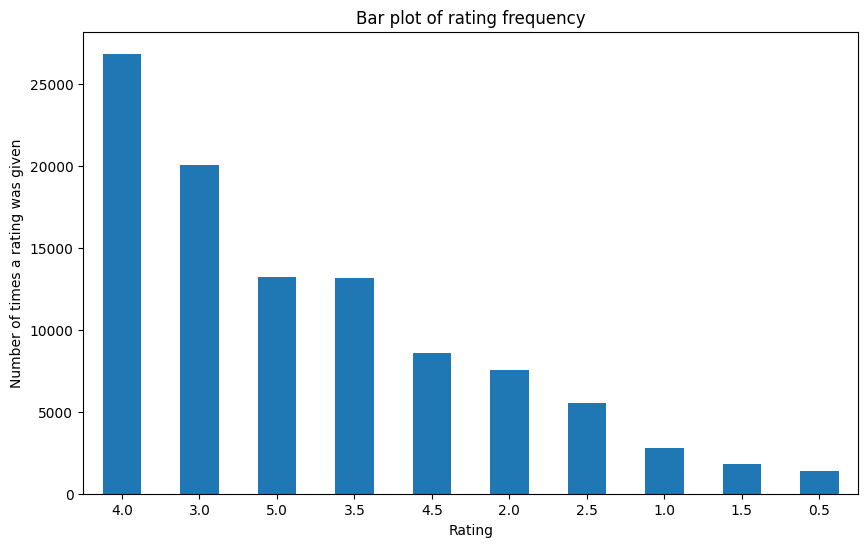

In [8]:
merge_dataset['rating'].value_counts(ascending=False).plot(kind='bar' ,figsize=(10,6), use_index = True, rot=0)
plt.title('Bar plot of rating frequency')
plt.xlabel('Rating')
plt.ylabel('Number of times a rating was given')

From this plot we can conclude that rating of 4.0 for movies was given more frequantly than other ratings.Let's find the top 10 movies.

Let's find the average rating of each movie by users rating.

In [9]:
avg_ratings = ratings.groupby('movieId')['rating'].mean().reset_index(name='avg_rating')
avg_ratings.head()

,movieId,avg_rating
0,1,3.920930
1,2,3.431818
2,3,3.259615
3,4,2.357143
4,5,3.071429


I use the TMDB Ratings to come up with our Top Movies Chart. I will use IMDB's weighted rating formula to construct my chart. Mathematically, it is represented as follows:

Weighted Rating (WR) =   (vv+m.R)+(mv+m.C)
 
 

where,

v is the number of votes for the movie
m is the minimum votes required to be listed in the chart
R is the average rating of the movie
C is the mean vote across the whole report
The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [10]:
new_ratings = pd.merge(avg_ratings,count_ratings,how='inner',on='movieId')
new_ratings=pd.merge(new_ratings,mv,how='inner',on='movieId')
new_ratings.head()

,movieId,avg_rating,vote_count,title,genres
0,1,3.920930,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,3.431818,110,Jumanji (1995),Adventure|Children|Fantasy
2,3,3.259615,52,Grumpier Old Men (1995),Comedy|Romance
3,4,2.357143,7,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,3.071429,49,Father of the Bride Part II (1995),Comedy


In [11]:
C = new_ratings['avg_rating'].mean()
C

3.262448274810963

In [12]:
m = new_ratings['vote_count'].quantile(0.95)
m

47.0

In [14]:
qualified = new_ratings[(new_ratings['vote_count'] >= m) & (new_ratings['vote_count'].notnull()) & (new_ratings['avg_rating'].notnull())][['title', 'genres', 'vote_count', 'avg_rating']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['avg_rating'] = qualified['avg_rating'].astype('int')
qualified.shape

(491, 4)

Therefore we have at least the 491 films with the more the 47 votes.

In [15]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['avg_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [16]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [17]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [19]:
qualified.head(15)

,title,genres,vote_count,avg_rating,wr
314,Forrest Gump (1994),Comedy|Drama|Romance|War,329,4,3.907806
277,"Shawshank Redemption, The (1994)",Crime|Drama,317,4,3.904767
257,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307,4,3.902076
510,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279,4,3.893666
1938,"Matrix, The (1999)",Action|Sci-Fi|Thriller,278,4,3.893339
224,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,251,4,3.883675
97,Braveheart (1995),Action|Drama|War,237,4,3.877940
461,Schindler's List (1993),Drama|War,220,4,3.870169
2224,Fight Club (1999),Action|Crime|Drama|Thriller,218,4,3.869189
897,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,211,4,3.865640


Upon reviewing the list, we observe that the movie "Forrest Gump" holds the top position, with an average rating of 4 and 329 votes. This list can be suggested to new users as a recommended watchlist. Additionally, we can compile a list of popular movies based on genres and suggest it to new subscribers when they sign up for the streaming service.

### Content Based filtering

The recommender system I previously developed has its limitations as it does not cater to the individual user's preferences. Rather, it relies on ratings from various users, whose tastes may not be similar to that of the particular user. Therefore, implementing Content Based filtering can enhance the recommender system. This technique identifies similarities between products, in this case, movies, across the dataset.\
For instance, if a user enjoys a movie like The Matrix, which falls under the genres of Action, Sci-Fi, and Thriller, we can identify similar movies from the same genres to recommend to the user.\
The data used in the previous stage is insufficient in terms of features required for this type of recommender. To enhance the system, we need to incorporate additional information such as the cast, actors, and movie descriptions.\
For this case we are going to use the data set from Kaggle https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

In [110]:
metadata = pd.read_csv("../kaggle_dataset/movies_metadata.csv") 
metadata = metadata.iloc[0:10000,:] #taking only 10000 samples from data set

keywords = pd.read_csv("../kaggle_dataset/keywords.csv")
credits= pd.read_csv("../kaggle_dataset/credits.csv") 
metadata.head()

/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_62562/2577693991.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("../kaggle_dataset/movies_metadata.csv")


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [111]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
metadata['id'] = metadata['id'].astype('int')

metadata = metadata.merge(credits, on='id')
metadata = metadata.merge(keywords, on='id')

In [112]:
metadata['crew'] = metadata['crew'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [113]:
metadata['tagline'] = metadata['tagline'].fillna('')
metadata['description'] = metadata['overview'] + metadata['tagline']
metadata['description'] = metadata['description'].fillna('')


We are goint to use TfidVectorizer.\
TfidfVectorizer is a feature extraction technique used in Content Based filtering, a method used in recommender systems. It stands for "Term Frequency-Inverse Document Frequency Vectorizer."

TfidfVectorizer converts the textual data of movie descriptions, plot summaries, and cast information into a matrix of numerical values, where each row represents a movie, and each column represents a unique word. The numerical values in the matrix correspond to the importance of each word in the movie's description, with higher values assigned to words that are unique to a specific movie and lower values assigned to words that appear frequently across all movies.
<br>
Possible to create the feature metrix not obly on film description either on crew,cast and genre.

In [114]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(metadata['description'])
tfidf_matrix.shape

(10048, 300392)

##### Cosine similarity

Cosine similarity is the calculation over two vectors two find similarity between them. Mathematically, it is defined as follows:$$cosine(x,y)=(xy^T)/(||x||*||y||)$$

We have generated a matrix comprising all the vector features for each movie, which has already been normalized. In this scenario, we can utilize the linear kernel, represented by the formula $$kernel(x,y)=(xy^T)$$ This approach can facilitate the identification of similar movies based on their vector features, thereby enhancing the precision of the recommender system.

In [115]:
similarity = linear_kernel(tfidf_matrix,tfidf_matrix)

At this stage, we have computed a pairwise cosine similarity matrix for all the movies in our dataset. Our subsequent task involves developing a function that can extract the 30 most similar movies based on the cosine similarity score.

In [116]:
metadata = metadata.reset_index()
titles = metadata['title']
indices = pd.Series(metadata.index, index=metadata['title'])

In [137]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [139]:
get_recommendations('The Matrix').head(10)

3088                Supernova
603     Hellraiser: Bloodline
167                   Hackers
9206                 Takedown
1360                 Sneakers
9417            The Animatrix
6548                 Commando
4594           Thomas in Love
9644          Freedomfighters
3796             The Specials
Name: title, dtype: object

In [142]:
get_recommendations('Superman').head(10)

9215    The Batman Superman Movie: World's Finest
2541             Superman IV: The Quest for Peace
2539                                  Superman II
7949                                 Spider-Man 2
6855                                 The Freshman
5480                        Monster in the Closet
6262                                  The In-Laws
7813                                  The ComDads
6298                           Destry Rides Again
6965                           Play It Again, Sam
Name: title, dtype: object

We have observed that our system can identify "Superman" movie as a film from the Marvel like other Superman's movie, Spider-Man and Batman. However, this is the limit of our system's capabilities at the moment. The current model does not take into account critical features such as cast, crew, director, and genre, which significantly impact a movie's rating and popularity. For instance, a person who enjoyed "The Matrix" would most likely have liked it due to the involvement of KeanuReeves, and might not enjoy other substandard movies in the recomendation based on "The Matrix". So we can improve our model to take into count, crew,cast,genre as well.

### Collaborative filtering 
Constant-based filtering only recommends movies based on factors such as movie similarity, ratings, and number of votes. However, this method is limited in that it can only suggest movies that are similar to a certain movie, and it does not take into account the specific tastes of individual users.\
\
Additionally, models that are not personalized enough are not based on a user's perfect watches, likes, or other rated movies, and anyone who uses these models will receive the same list of movies, meaning that these models are not user-directed.\
\
Collaborative filtering, on the other hand, addresses these issues by focusing on individual users and learning and recognizing their preferences to create personalized lists of movies and shows.\
I'm going to implement two diffrent methods like **Singular Value Decomposition (SVD)** and **Matrix Factorization**.

In [2]:
ratings = pd.read_csv(filepath_or_buffer="../kaggle_dataset/ratings_small.csv",dtype={'userId': 'int32', 'movieId': 'int32','timestamp':'int32','rating': 'float32'})
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
rdr = Reader()
dataset=Dataset.load_from_df(ratings[['movieId','userId','rating']],rdr)
svd =SVD()
cross_validate(svd,dataset,measures=['RMSE','MAE'],cv =5)

{'test_rmse': array([0.89272613, 0.90883492, 0.8986807 , 0.89366777, 0.90199978]),
 'test_mae': array([0.68708605, 0.69969851, 0.69463875, 0.68985882, 0.69455711]),
 'fit_time': (0.8812410831451416,
  0.9046139717102051,
  0.9159560203552246,
  0.9209179878234863,
  0.897150993347168),
 'test_time': (0.15082693099975586,
  0.21073317527770996,
  0.13639616966247559,
  0.21301984786987305,
  0.13777709007263184)}

In [6]:
trainset = dataset.build_full_trainset()
svd.fit(trainset)

In [7]:
ratings[ratings["userId"]==25]

,userId,movieId,rating
4755,25,3,3.0
4756,25,32,4.0
4757,25,78,3.0
4758,25,104,4.0
4759,25,260,4.0
4760,25,494,3.0
4761,25,608,3.0
4762,25,653,2.0
4763,25,663,2.0
4764,25,707,3.0


In [8]:
svd.predict('25','842')

Prediction(uid='25', iid='842', r_ui=None, est=3.543608255669773, details={'was_impossible': False})